In [1]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading
import dimensionality_estimation

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
import itertools
from scipy import stats
import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
functions.set_plotting_defaults()
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate suitable sessions

### list out n cells for grosmark

In [97]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]
for basepath in df.basepath.unique():
    st,cell_metrics = loading.load_spikes(basepath,
                                        brainRegion='CA1',
                                        putativeCellType='Pyramidal Cell')
    print(basepath)
    print(st)

Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
<SpikeTrainArray at 0x23222265520: 241 units> at 20000 Hz
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013
<SpikeTrainArray at 0x23263a312b0: 94 units> at 20000 Hz
Z:\Data\GrosmarkAD\Buddy\Buddy_06272013
<SpikeTrainArray at 0x23263881cd0: 47 units> at 20000 Hz
Z:\Data\GrosmarkAD\Cicero\Cicero_09012014
<SpikeTrainArray at 0x23263b471c0: 55 units> at 20000 Hz
Z:\Data\GrosmarkAD\Cicero\Cicero_09102014
<SpikeTrainArray at 0x23263528760: 79 units> at 20000 Hz
Z:\Data\GrosmarkAD\Cicero\Cicero_09172014
<SpikeTrainArray at 0x232638c38e0: 59 units> at 20000 Hz
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013
<SpikeTrainArray at 0x23263535ee0: 65 units> at 20000 Hz
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013
<SpikeTrainArray at 0x2326368c5e0: 38 units> at 20000 Hz


### find sessions with enough cells and enough ripples per epoch

In [113]:
importlib.reload(loading)
st,cell_metrics = loading.load_spikes(basepath,
                                    putativeCellType='Pyramidal Cell',
                                    brainRegion='CA1')
print(cell_metrics.putativeCellType.unique())
print(cell_metrics.brainRegion.unique())

st,cell_metrics = loading.load_spikes(basepath,
                                    putativeCellType='Pyramidal',
                                    brainRegion=['CA1','CA3'])
print(cell_metrics.putativeCellType.unique())
print(cell_metrics.brainRegion.unique())

['Pyramidal Cell']
['CA1']
['Pyramidal Cell']
['CA1' 'CA3DG']


In [52]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
cell_metrics = loading.load_all_cell_metrics(df.basepath.unique())

In [57]:
cell_metrics[(cell_metrics.animal == 'HMC1') & (cell_metrics.brainRegion.str.contains('CA1')) & (cell_metrics.putativeCellType.str.contains('Pyramidal'))] 

,UID,ab_ratio,acg_asymptote,acg_c,acg_d,acg_fit_rsquare,acg_h,acg_refrac,acg_tau_burst,acg_tau_decay,...,spatialCoverageIndex,spatialGiniCoeff,spatialPeakRate,SWR_modulationIndex,SWR_modulationPeakResponseTime,SWR_modulationSignificanceLevel,pulses_modulationIndex,pulses_modulationPeakResponseTime,pulses_modulationSignificanceLevel,phy_amp
24179,1,-0.322755,6.930582,25.564755,1.547706,0.975482,48.788923,5.928451,0.871598,10.753093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.179840
24180,2,-0.320183,2.539844,28.281262,0.867166,0.972692,87.198813,5.398365,0.849320,8.381278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.340696
24181,3,-0.528562,3.192529,24.008325,2.005757,0.980048,61.253302,7.502633,1.374953,11.458779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.653179
24182,4,-0.565238,2.135149,16.581143,1.963042,0.993054,47.276844,5.627614,0.659531,7.363767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.280403
24183,5,-0.351204,6.834716,21.213779,1.313730,0.956129,33.813476,5.545638,1.104237,14.961637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.747978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24272,94,-0.499617,2.053506,32.806178,1.244803,0.950055,46.246915,5.027733,0.786050,11.947693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.735168
24273,95,-0.168353,3.443739,9.701756,1.826260,0.948632,20.384791,7.493126,1.519469,12.123529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.810001
24274,96,-0.535352,1.562736,19.258266,1.714672,0.919042,41.365953,6.289643,1.359248,15.752700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.487030
24275,97,-0.333959,6.727615,47.467922,0.850041,0.976751,67.144783,4.673066,0.671442,9.029353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.686241


In [59]:
cell_metrics[(((cell_metrics.brainRegion.str.contains('CA1')) |
                (cell_metrics.brainRegion.str.contains('CA3')) |
                (cell_metrics.brainRegion.str.contains('CA2'))) &
                (cell_metrics.putativeCellType.str.contains('Pyramidal')) &
                (cell_metrics.bad_unit == False))].basepath.value_counts()[:30]

Z:\Data\GrosmarkAD\Achilles\Achilles_10252013    241
Z:\Data\AYAold\AB4\day11                         168
Z:\Data\AYAold\AB4\day09                         159
Z:\Data\ORproject\OR15\day10                     141
Z:\Data\AYAold\AB4\day07                         136
Z:\Data\AYAold\AYA9\day17                        132
Z:\Data\ORproject\OR22\day3                      125
Z:\Data\AYAold\AYA9\day20                        121
Z:\Data\AYAold\AYA10\day25                       117
Z:\Data\AYAold\AB3\AB3_60                        116
Z:\Data\AYAold\AYA7\day24                        115
Z:\Data\AYAold\AYA7\day25                        112
Z:\Data\ORproject\OR22\day5                      110
Z:\Data\ORproject\OR22\day4                      108
Z:\Data\AYAold\AB4\day08                         107
Z:\Data\AYAold\AB4\day03                         105
Z:\Data\AYAold\AYA10\day31                       103
Z:\Data\AYAold\AB3\AB3_58_59                     101
Z:\Data\AYAold\AB3\AB3_38_41                  

## Demonstration to show how dependent the analysis is on n cells

Slope increases when adding neurons. $>100$ pyr cells explain  $\sim40%$ of shared variance with first dimension. Shared variance is $\sim 65$

In [9]:
basepath = r'Z:\Data\GrosmarkAD\Achilles\Achilles_10252013'
(cell_metrics,
st,
epoch_df,
behavioral_epochs,
nrem_epochs,
wake_epochs,
ripple_epochs,
unit_mat) = dimensionality_estimation.load_needed_data(basepath,par_type='firing_rate')

unit_mat = unit_mat.zscore()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:236: UserWarning: fs was not specified, so we try to estimate it from the data...
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.7961783439494228 Hz


In [10]:
scov = []
varcov = []
strain = []
stest = []
svc_neur = []
for i in np.arange(20,unit_mat.data.shape[0],20):
    scov_,varcov_,strain_,stest_ = dimensionality_estimation.SVCA_(unit_mat.data[0:i])
    scov.append(scov_)
    varcov.append(varcov_)
    strain.append(strain_)
    stest.append(stest_)
    svc_neur.append(scov_ / varcov_)

In [ ]:
importlib.reload(dimensionality_estimation)
slope, intercept, r2 = dimensionality_estimation.estimate_slope(np.array(svc_neur))

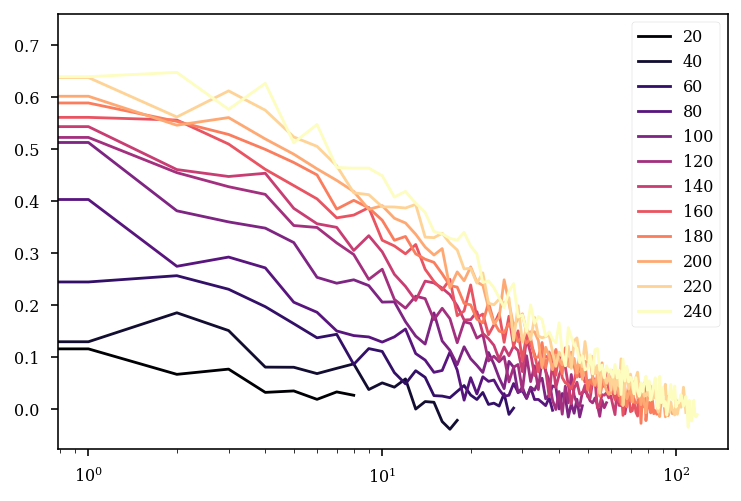

In [135]:
cmap = cm.get_cmap('magma',len(svc_neur))
n_cells = np.arange(20,unit_mat.data.shape[0],20)
for i,x in enumerate(svc_neur):
    plt.plot(x,color=cmap(i),label=str(n_cells[i]))
plt.xscale('log')
plt.legend(loc='upper right')


## Demonstrate how analysis is dependent on n ripples

Estimation is poor with $<100$ ripples and slope decreases with more ripples ~$>5000$ 

In [127]:
basepath = r'Z:\Data\GrosmarkAD\Achilles\Achilles_10252013'
(cell_metrics,
st,
epoch_df,
behavioral_epochs,
nrem_epochs,
wake_epochs,
ripple_epochs,
unit_mat) = dimensionality_estimation.load_needed_data(basepath,par_type='firing_rate')
unit_mat = unit_mat.zscore()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:236: UserWarning: fs was not specified, so we try to estimate it from the data...
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.7961783439494228 Hz


In [163]:
scov = []
varcov = []
strain = []
stest = []
svc_neur = []
x = np.round(np.logspace(np.log10(10), np.log10(unit_mat.data.shape[1]), num=15)).astype(int)

for i in x:
    scov_,varcov_,strain_,stest_ = dimensionality_estimation.SVCA_(unit_mat.data[:,0:i])
    scov.append(scov_)
    varcov.append(varcov_)
    strain.append(strain_)
    stest.append(stest_)
    svc_neur.append(scov_ / varcov_)

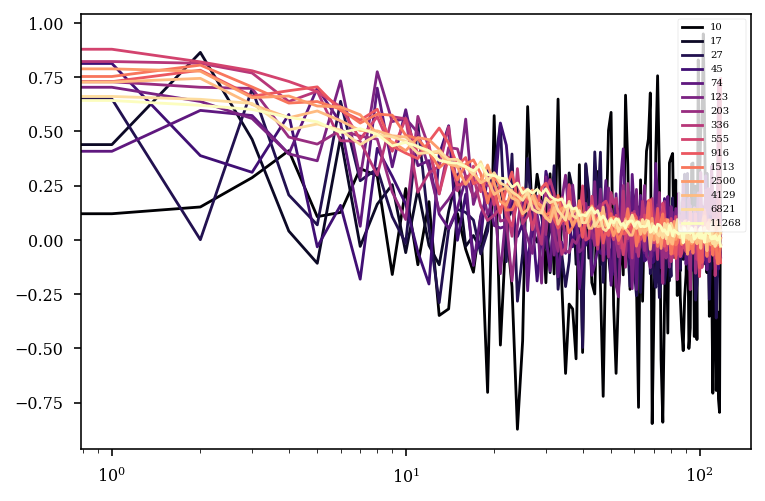

In [165]:
cmap = cm.get_cmap('magma',len(svc_neur))
n_ripples = np.round(np.logspace(np.log10(10), np.log10(unit_mat.data.shape[1]), num=15)).astype(int)
for i,x in enumerate(svc_neur):
    plt.plot(x,color=cmap(i),label=str(n_ripples[i]))
plt.xscale('log')
plt.legend(loc='upper right',fontsize=5)

# Main analysis

In [202]:
# cell_metrics = loading.load_all_cell_metrics(df.basepath)

In [201]:
# cell_metrics[cell_metrics.putativeCellType.str.contains('Pyramidal') & cell_metrics.brainRegion.str.contains('CA1')].basepath.value_counts()


### find sessions with enough cells that have pre/task/post

In [3]:
# find out which sessions have pre/task/post
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
epochs = pd.DataFrame()
for basepath in df.basepath:
    temp_df = loading.load_epoch(basepath)
    temp_df['basepath'] = basepath
    epochs = pd.concat([epochs,temp_df],ignore_index=True)
for basepath in epochs.basepath.unique():
    pre_task_post,_ = functions.find_pre_task_post(epochs[epochs.basepath == basepath].environment)
    epochs.loc[epochs.basepath == basepath,'pre_task_post'] = pre_task_post is not None
cell_metrics = loading.load_all_cell_metrics(epochs[epochs.pre_task_post].basepath.unique())
# find remaining sessions with >80 pyr ca1 units
grp_basepath = cell_metrics[(cell_metrics.putativeCellType.str.contains('Pyr') &
                             cell_metrics.brainRegion.str.contains('CA1'))].basepath.value_counts() > 80
basepaths = grp_basepath[grp_basepath.values].index

### find sessions with enough ripples in each epoch

In [4]:
session_good = []
for basepath in basepaths:
    # basepath = basepaths[0]
    # behavioral epochs
    epoch_df = loading.load_epoch(basepath)
    behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                    epoch_df.stopTime]).T])

    # get brain states                                                
    state_dict = loading.load_SleepState_states(basepath)
    nrem_epochs = nel.EpochArray(state_dict['NREMstate'])
    wake_epochs = nel.EpochArray(state_dict['WAKEstate'])

    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    pre_task_post,pre_task_post_ind = functions.find_pre_task_post(epochs[epochs.basepath == basepath].environment)
    n_ripples = []
    n_ripples.append(ripple_epochs[behavioral_epochs[pre_task_post_ind][0]][nrem_epochs].n_intervals)
    n_ripples.append(ripple_epochs[behavioral_epochs[pre_task_post_ind][1]][wake_epochs].n_intervals)
    n_ripples.append(ripple_epochs[behavioral_epochs[pre_task_post_ind][2]][nrem_epochs].n_intervals)

    session_good.append(all(np.array(n_ripples) >= 100))

basepaths = basepaths[session_good]

In [11]:
importlib.reload(dimensionality_estimation)
# df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
# df = df[df.basepath.str.contains('GrosmarkAD') | df.basepath.str.contains('HMC1') | df.basepath.str.contains('ORproject')]
df = pd.DataFrame()
df['basepath'] = basepaths

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\svc_analysis_bst_false_good_sessions'
dimensionality_estimation.main_run(df,save_path,parallel=True,use_bst=False)

In [12]:
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\svc_analysis_bst_v2'
importlib.reload(functions)
sessions = glob.glob(save_path +os.sep+ '*.pkl')
df = pd.DataFrame()
slope = []
slope_shuff = []
epochs_ = ['pre','task','post','shuffle']
epochs = []
results_df = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    epoch_df = loading.load_epoch(results['basepath'])
    pre_task_post,_ = functions.find_pre_task_post(epoch_df.environment)
    if pre_task_post is None:
        continue
    temp_df = pd.DataFrame()
    slope = [np.hstack(np.array(results['slope'])[pre_task_post]),results['slope_shuff'][0][0]]
    temp_df['slope'] = np.hstack(slope)
    temp_df['epochs'] = epochs_
    temp_df['basepath'] = results['basepath']
    results_df = pd.concat([results_df,temp_df],ignore_index=True)
results_df

,slope,epochs,basepath
0,-0.130642,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,-0.246260,task,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,-0.124031,post,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,-0.047797,shuffle,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,-0.150163,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013
5,-0.289654,task,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013
6,-0.277045,post,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013
7,-0.025795,shuffle,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013
8,-0.180855,pre,Z:\Data\HMC1\day8
9,-0.240578,task,Z:\Data\HMC1\day8


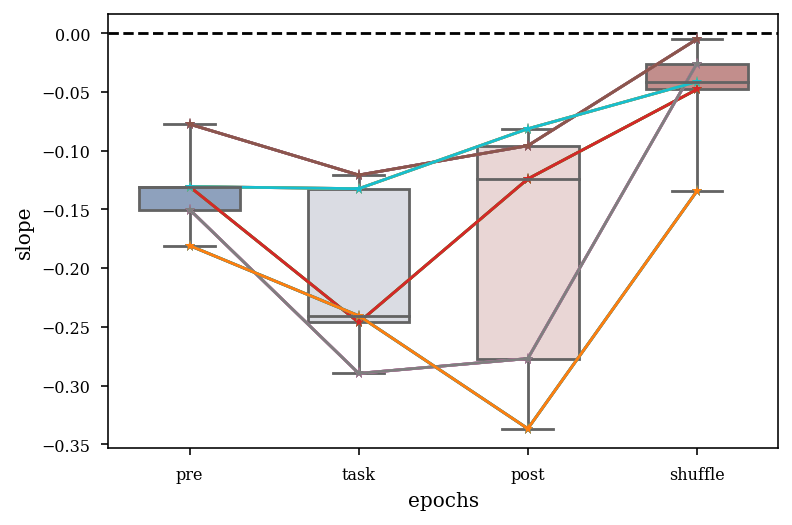

In [13]:
sns.boxplot(x="epochs", y="slope", data=results_df,
            whis=[0, 100], width=.6, palette="vlag")

# ,hue_order=['pre','post','task','shuffle']
# Add in points to show each observation
# sns.stripplot(x="epochs", y="slope", data=results_df,
#               size=4, color=".3", linewidth=0)
plt.axhline(0,color='k',linestyle='--')

for basepath in results_df.basepath:
    plt.plot(results_df[results_df.basepath == basepath].epochs,results_df[results_df.basepath == basepath].slope,marker='*')

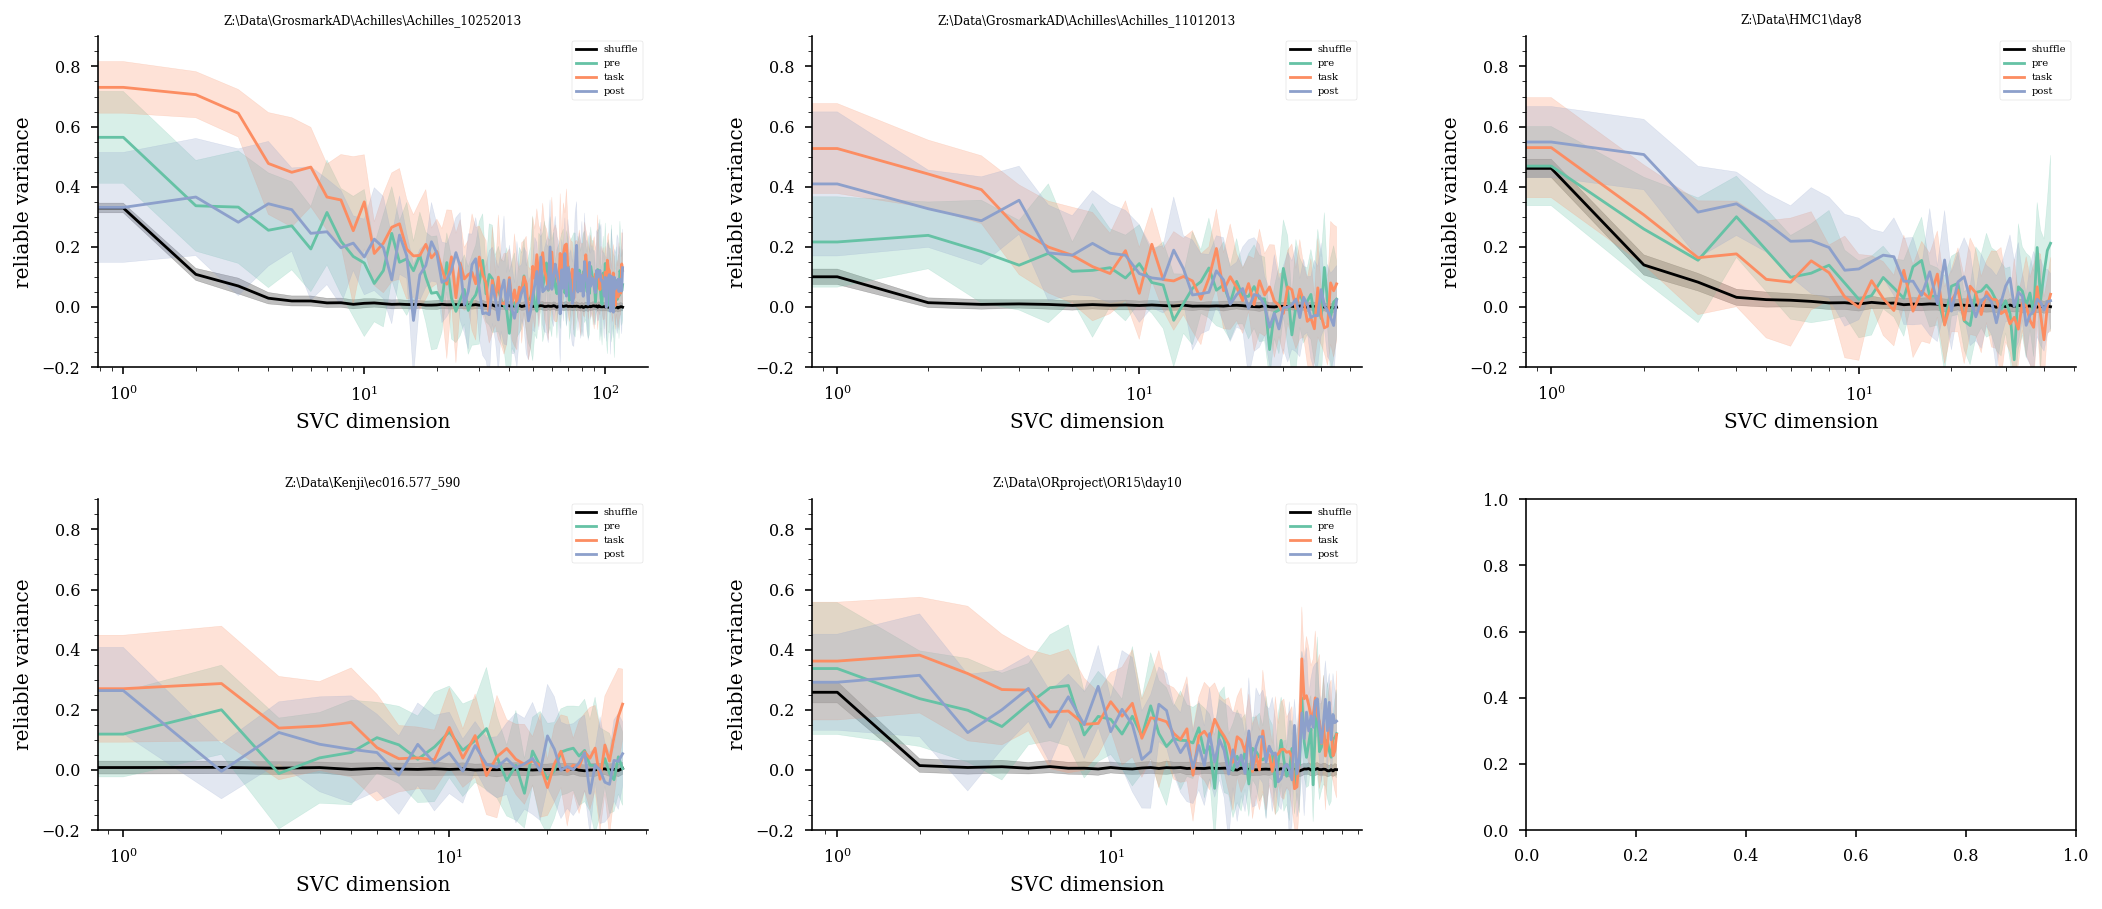

In [16]:
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\svc_analysis_bst_v2'

sessions = glob.glob(save_path +os.sep+ '*.pkl')

# fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(1,1)),constrained_layout=False)
fig, axs = plt.subplots(2,int(np.ceil(len(sessions)/2)), figsize=functions.set_size('thesis', fraction=3, subplots=(2,3)))
fig.subplots_adjust(hspace = 0.4, wspace=.3)
axs = axs.ravel()

for i,session in enumerate(sessions):

    with open(session, 'rb') as f:
        results = pickle.load(f)

    svc_neur = results['svc_neur']
    svc_neur_shuff = np.array(results['svc_neur_shuff'])

    axs[i].plot(svc_neur_shuff.mean(axis=0),color='k',alpha=1,label='shuffle')
    axs[i].fill_between(np.arange(svc_neur_shuff.shape[1]),
                    svc_neur_shuff.mean(axis=0)-svc_neur_shuff.std(axis=0),
                    svc_neur_shuff.mean(axis=0)+svc_neur_shuff.std(axis=0),
                    color='k',alpha=.25)
    axs[i].set_title(results['basepath'],fontsize=6)
    cmap = cm.get_cmap('Set2',8)

    labels = ['pre','task','post']

    epoch_df = loading.load_epoch(results['basepath'])
    pre_task_post,_ = functions.find_pre_task_post(epoch_df.environment)
    if pre_task_post is None:
        continue

    # epoch_df = loading.load_epoch(results['basepath'])

    for ep,env in enumerate(labels):
        svc_neur_ = np.array(svc_neur)[pre_task_post][ep]
        axs[i].plot(np.nanmean(svc_neur_,axis=0),color=cmap(ep),alpha=1,label=env)
        axs[i].fill_between(np.arange(svc_neur_.shape[1]),
                        np.nanmean(svc_neur_,axis=0)-np.nanstd(svc_neur_,axis=0),
                        np.nanmean(svc_neur_,axis=0)+np.nanstd(svc_neur_,axis=0),
                        color=cmap(ep),alpha=.25)

    # ax = plt.gca()
    axs[i].set_xscale('log')

    # plt.xlim(0,10**2)
    axs[i].set_ylim(-.2,.9)

    axs[i].set_xlabel('SVC dimension')
    axs[i].set_ylabel('reliable variance')
    axs[i].legend(fontsize=5)

    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

In [17]:
def pairwise_corr(unit_mat):
    x = np.arange(0,unit_mat.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        rho_, pval_ = stats.spearmanr(unit_mat[s[0],:], unit_mat[s[1],:])
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c

importlib.reload(functions)
basepath = df.basepath.unique()[0]

cell_metrics,data,ripples,fs_dat = loading.load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))  
                    
# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit_rip = st_unit[ripple_epochs]

spk_count_rip = functions.get_participation(st_unit.data,ripples.start.values,ripples.stop.values,par_type='counts')

rho,pval,c = pairwise_corr(spk_count_rip)

temp_df = pd.DataFrame()
temp_df['ref'] = c[:,0]
temp_df['target'] = c[:,1]
temp_df['UID_ref'] = cell_metrics.UID.iloc[temp_df['ref']].values
temp_df['UID_target'] = cell_metrics.UID.iloc[temp_df['target']].values
temp_df['rho'] = rho
temp_df['pval'] = pval
temp_df['deepSuperficial_ref'] = cell_metrics.deepSuperficial.iloc[temp_df['ref']].values
temp_df['deepSuperficial_target'] = cell_metrics.deepSuperficial.iloc[temp_df['target']].values
temp_df['basepath'] = basepath

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
temp_df

,ref,target,UID_ref,UID_target,rho,pval,deepSuperficial_ref,deepSuperficial_target,basepath
0,0,1,1,3,0.029471,1.755862e-03,Deep,Superficial,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,0,2,1,4,0.028926,2.134949e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,0,3,1,5,-0.001878,8.419785e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,0,4,1,7,-0.003942,6.756905e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,0,5,1,9,-0.030480,1.212511e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
...,...,...,...,...,...,...,...,...,...
28915,237,239,272,274,0.022569,1.658589e-02,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28916,237,240,272,275,0.029005,2.075299e-03,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28917,238,239,273,274,0.150396,5.333362e-58,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
28918,238,240,273,275,0.004501,6.328206e-01,Deep,Deep,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013


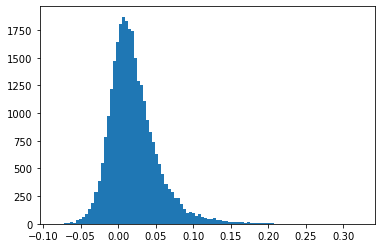

In [16]:
plt.hist(temp_df.rho,100)
plt.show()

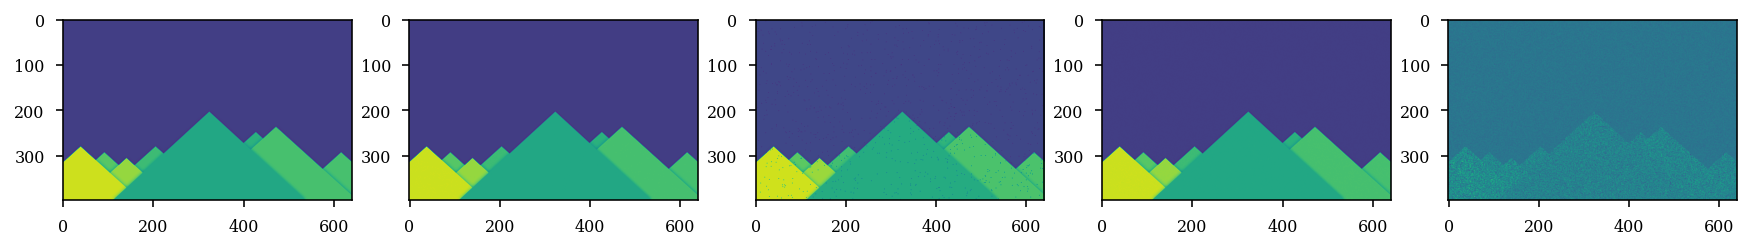

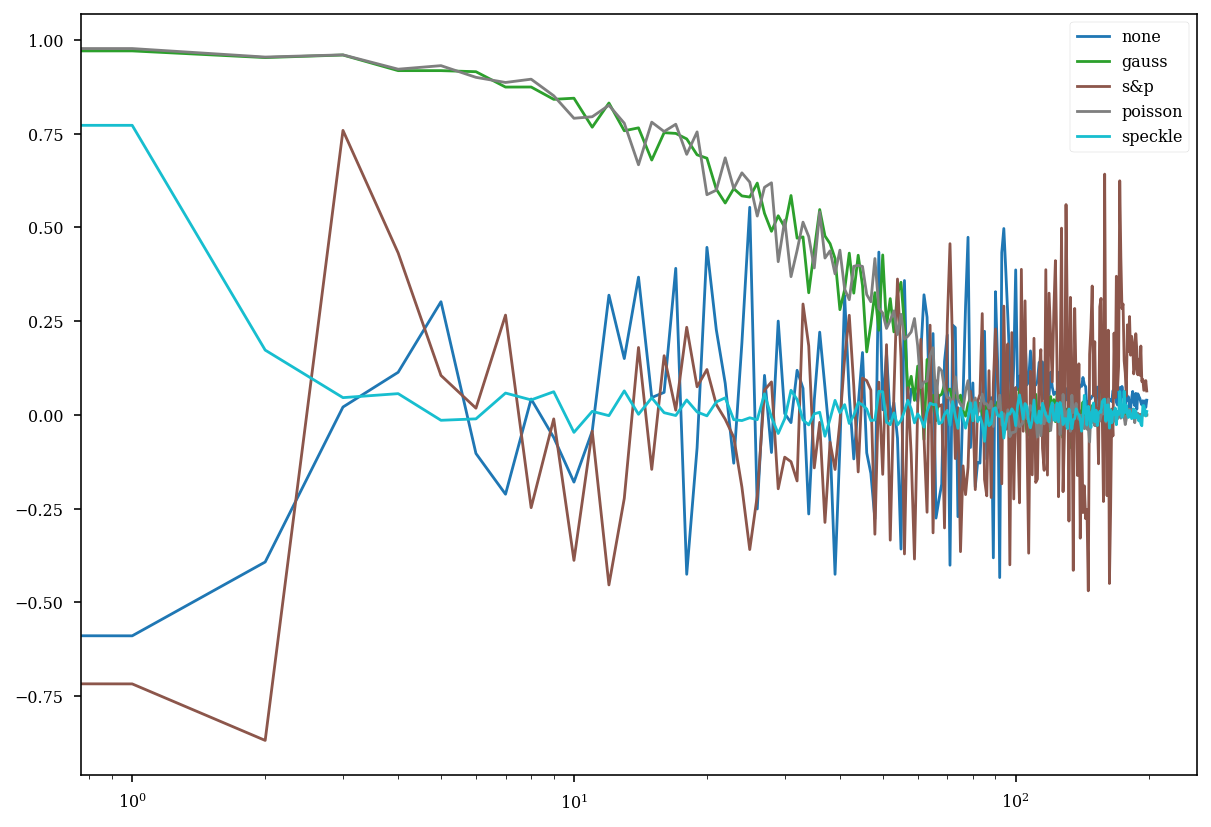

In [230]:
def noisy(noise_typ,image):
    """
    Parameters
    ----------
    image : ndarray
        Input image data. Will be converted to float.
    mode : str
        One of the following strings, selecting the type of noise to add:

        'gauss'     Gaussian-distributed additive noise.
        'poisson'   Poisson-distributed noise generated from the data.
        's&p'       Replaces random pixels with 0 or 1.
        'speckle'   Multiplicative noise using out = image + n*image,where
                    n is uniform noise with specified mean & variance.


    """
    if noise_typ == "gauss":
        row,col = image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy
    elif noise_typ == 'none':
        return image

import cv2
img_grey = cv2.imread(r'C:\Users\Cornell\Downloads\cv2-resize-image-original.png', cv2.IMREAD_GRAYSCALE)
thresh = 128
img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]

# X = np.random.rand(100,100)
X = img_grey

fig,ax = plt.subplots(1,5,figsize=(15,15))
ax[0].imshow(X)
ax[1].imshow(noisy('gauss',X))
ax[2].imshow(noisy('s&p',X))
ax[3].imshow(noisy('poisson',X))
ax[4].imshow(noisy('speckle',X))
plt.show()

plt.figure(figsize=(10,7))
# X = np.random.rand(100,1000)
cmap = cm.get_cmap('tab10',5)
for i,noise_types in enumerate(['none','gauss','s&p','poisson','speckle']):
    svc_neur,_,_,_,_ = dimensionality_estimation.SVCA(noisy(noise_types,X),folds=5)
    svc_neur = np.array(svc_neur)
    plt.plot(svc_neur.mean(axis=0),color=cmap(i),alpha=1,label=noise_types)
plt.xscale('log')
plt.legend()

In [25]:
def SVCA_v2(Ff, npc, ntrain, ntest, itrain, itest):
    """
    computes a cross-validated form of PCA: Shared Variance Component
    Analysis. Components are extracted from the covariance between neuron
    sets "ntrain" and "ntest" on training timepts "itrain". The variance of
    these covariance components is computed on testing timepts "itest". 
    This variance is the amount of reliable variance of that component 
    (because it's consistent across timepts). 
    Why compute it in the covariance space?
    we assume the covariance btw/ neurons is consistent across time 
    - we have no other metric to track because we are not presenting stimuli
    INPUTS:
        Ff (neurons x timepts)
        npc (number of PCs to compute)
        ntrain (one half of neurons)
        ntest (other half of neurons)
        itrain (one half of timepts)
        itest (other half of timepts)
    OUTPUTS:
        sneur (shared variance of each covariance component)
        vneur (total variance of each covariance component)
        u (left eigenvectors of covariance matrix btw ntrain and ntest on
        itrain timepts)
        v (right eigenvectors of covariance matrix btw ntrain and ntest on
        itrain timepts)

    From stringer-pachitariu-et-al-2018a
    https://github.com/MouseLand/stringer-pachitariu-et-al-2018a
    """
    cov = Ff[ntrain,itrain] * Ff[ntest,itrain].T
    u,s,v = np.linalg.svd(cov,full_matrices=False)
    u = u[:,0:npc]
    v = v[:,0:npc]
    s1 = u.T * Ff[ntrain,itest]
    s2 = v.T * Ff[ntest,itest]
    sneur = np.sum(s1 * s2, axis=1)
    varneur = np.sum(s1**2 + s2**2,axis=1) / 2
    return sneur, varneur, u, v

In [34]:
importlib.reload(functions)

<module 'functions' from 'D:\\github\\ripple_heterogeneity\\python\\functions.py'>

## using bst to find SVC

In [19]:
bst_rip = st_unit[ripple_epochs].bin(ds=.02)


<AxesSubplot:>

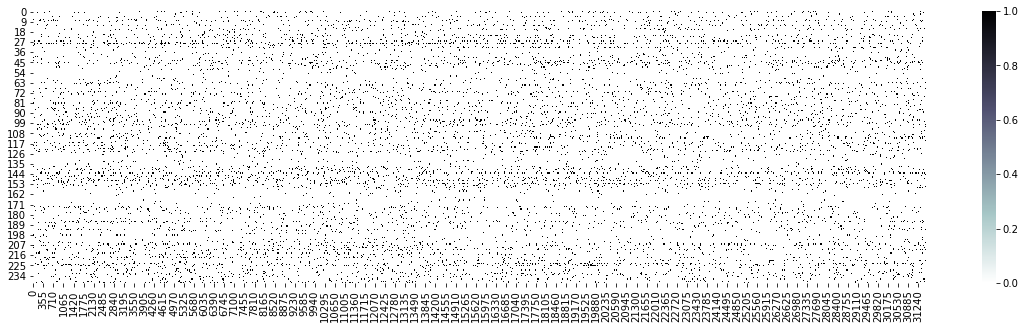

In [23]:
plt.figure(figsize=(20,5))
sns.heatmap(bst_rip.data,vmax=1,cmap='bone_r')

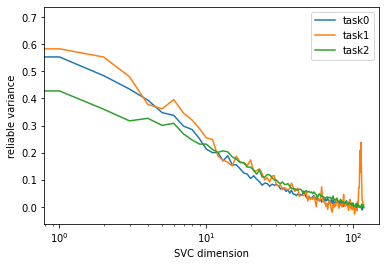

In [24]:
import warnings
warnings.filterwarnings("ignore")

plt.figure()
for i,ep in enumerate(beh_epochs):
    #  do multiple subsets and avg
    svc_neur = []
    for _ in range(10):
        scov,varcov,strain,stest = SVCA(bst_rip[ep].data)
        svc_neur.append(scov/varcov)

    plt.plot(np.mean(svc_neur,axis=0),label='task'+str(i))
    # plt.show()
plt.xscale('log')
plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')
plt.legend()


## Using participation matrix to find SVC

In [47]:
import dimensionality_estimation
importlib.reload(dimensionality_estimation)

scov = []
varcov = []
strain = []
stest = []
svc_neur = []
for i,ep in enumerate(beh_epochs):
  svc_neur_,scov_,varcov_,strain_,stest_ = dimensionality_estimation.SVCA(unit_mat[ep].data)
  scov.append(scov_)
  varcov.append(varcov_)
  strain.append(strain_)
  stest.append(stest_)
  svc_neur.append(svc_neur_)
        

In [172]:
print(beh_epochs[0])
print(beh_epochs[1])
print(beh_epochs[2])

<EpochArray at 0x20ce8fb5490: 1 epoch> of length 5:01:19:500 hours
<EpochArray at 0x20d25ee2a60: 1 epoch> of length 34:27:500 minutes
<EpochArray at 0x20d25ee0190: 1 epoch> of length 4:05:14:103 hours


In [168]:
print(unit_mat[beh_epochs[0]])
print(unit_mat[beh_epochs[1]])
print(unit_mat[beh_epochs[2]])

<AnalogSignalArray at 0x20c7c64cf70: 241 signals (4,803 segments)> for a total of 5:28:012 minutes
<AnalogSignalArray at 0x20ce8fb54f0: 241 signals (552 segments)> for a total of 35.0264 seconds
<AnalogSignalArray at 0x20d25ee01c0: 241 signals (5,913 segments)> for a total of 6:12:998 minutes


### look at curve over 100 ripple chunks

In [112]:
ts = unit_mat.abscissa_vals[np.arange(0,unit_mat.n_intervals,100)]
time_chunk_epochs = nel.EpochArray([np.array([ts[0:-2],ts[1:-1]]).T])
time_chunk_epochs

<EpochArray at 0x20c372b0eb0: 111 epochs> of length 9:30:47:580 hours

In [113]:
scov = []
varcov = []
strain = []
stest = []
svc_neur = []
for i,ep in enumerate(time_chunk_epochs):
  svc_neur_,scov_,varcov_,strain_,stest_ = dimensionality_estimation.SVCA(unit_mat[ep].data)
  scov.append(scov_)
  varcov.append(varcov_)
  strain.append(strain_)
  stest.append(stest_)
  svc_neur.append(svc_neur_)

In [115]:
len(svc_neur)

111

No handles with labels found to put in legend.


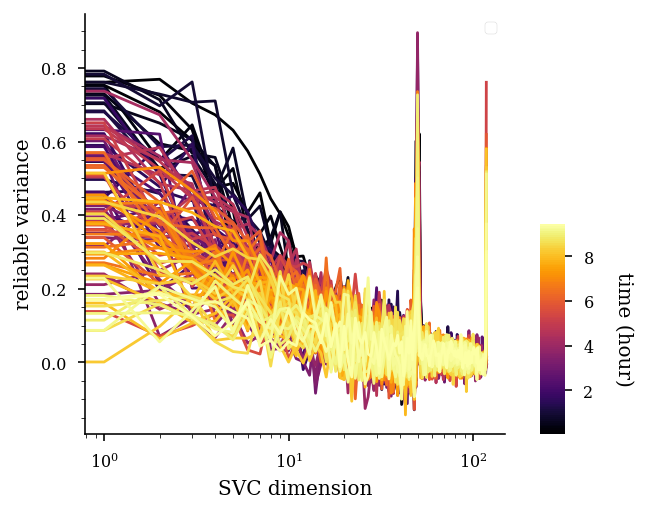

In [139]:
import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(1,1)),constrained_layout=False)

cmap = cm.get_cmap('inferno',len(svc_neur))

# labels = ['pre','task','post']
for i in range(len(svc_neur)):
    svc_neur_ = np.array(svc_neur[i])
    plt.plot(svc_neur_.mean(axis=0),color=cmap(i),alpha=1)
    # plt.fill_between(np.arange(svc_neur_.shape[1]),
    #                 svc_neur_.mean(axis=0)-svc_neur_.std(axis=0),
    #                 svc_neur_.mean(axis=0)+svc_neur_.std(axis=0),
    #                 color=cmap(i),alpha=.25)
ax = plt.gca()
plt.xscale('log')

ax.set_aspect(1./ax.get_data_ratio())
                   
# plt.xlim(0,10**2)
# plt.ylim(0,.8)

plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')
plt.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=time_chunk_epochs.centers.min()/60/60,vmax=time_chunk_epochs.centers.max()/60/60)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.75, 0.1, 0.03, 0.4])
cbar = plt.colorbar(sm,cax=cax)

cbar.set_label('time (hour)', rotation=270, labelpad=20)
cbar.outline.set_visible(False)
# plt.savefig(os.path.join(fig_save_path,'svc_ripple_dimension.svg'),dpi=300,bbox_inches='tight')


In [293]:
importlib.reload(dimensionality_estimation)
results = dimensionality_estimation.set_up_and_do_analysis(df.basepath.unique()[0],n_shuffles=10)

In [296]:
results['slope']

[array([-0.31485142]), array([-0.29302654]), array([-0.24475968])]

NameError: name 'cm' is not defined

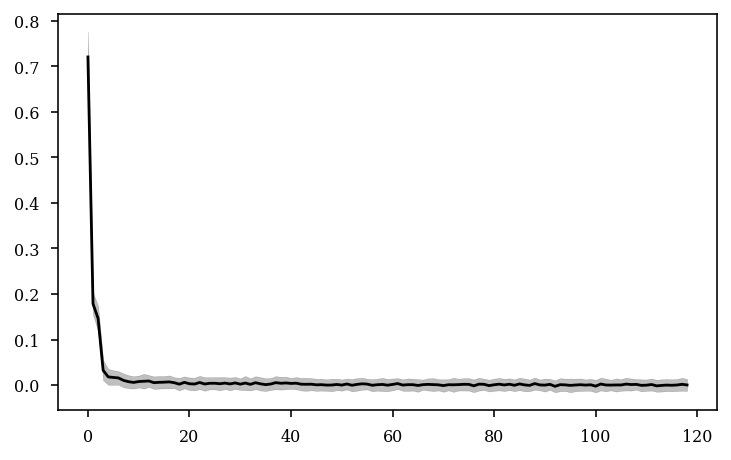

In [33]:
fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(1,1)),constrained_layout=False)

svc_neur = results['svc_neur']
svc_neur_shuff = np.array(results['svc_neur_shuff'])

plt.plot(svc_neur_shuff.mean(axis=0),color='k',alpha=1,label='shuffle')
plt.fill_between(np.arange(svc_neur_shuff.shape[1]),
                svc_neur_shuff.mean(axis=0)-svc_neur_shuff.std(axis=0),
                svc_neur_shuff.mean(axis=0)+svc_neur_shuff.std(axis=0),
                color='k',alpha=.25)

cmap = cm.get_cmap('Set2',8)

labels = ['pre','task','post']
for i in range(3):
    svc_neur_ = np.array(svc_neur[i])
    plt.plot(svc_neur_.mean(axis=0),color=cmap(i),alpha=1,label=labels[i])
    plt.fill_between(np.arange(svc_neur_.shape[1]),
                    svc_neur_.mean(axis=0)-svc_neur_.std(axis=0),
                    svc_neur_.mean(axis=0)+svc_neur_.std(axis=0),
                    color=cmap(i),alpha=.25)

ax = plt.gca()
plt.xscale('log')

ax.set_aspect(1./ax.get_data_ratio())
                
# plt.xlim(0,10**2)
plt.ylim(0,.8)

plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')
plt.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_title(basepath)

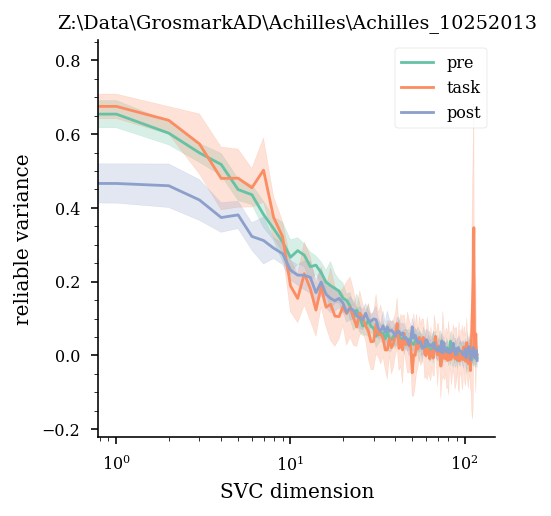

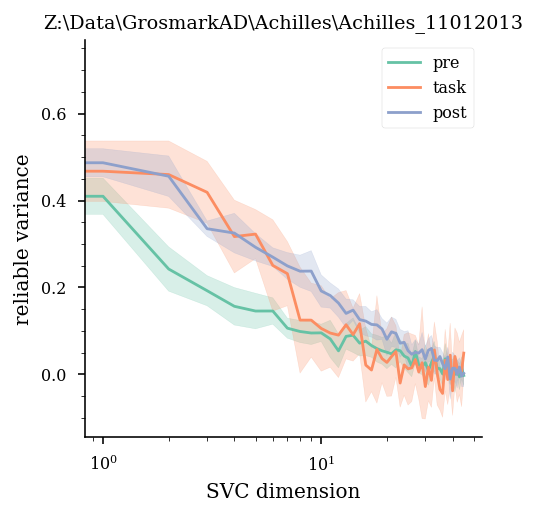

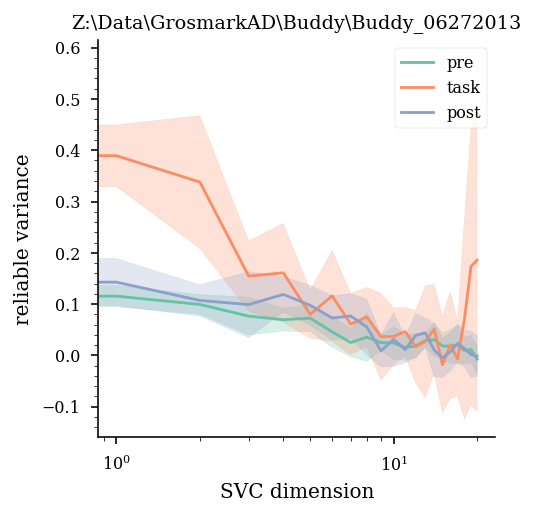

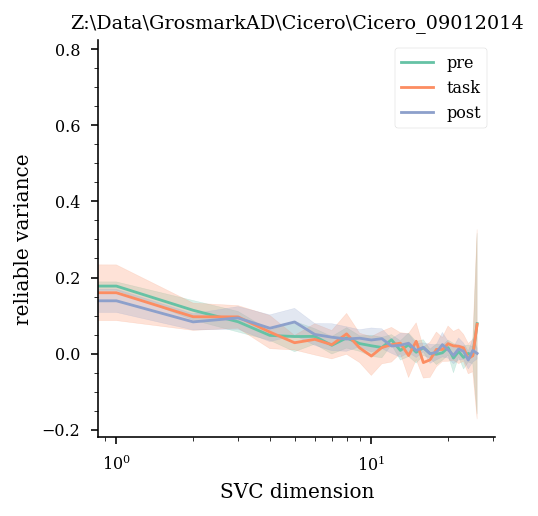

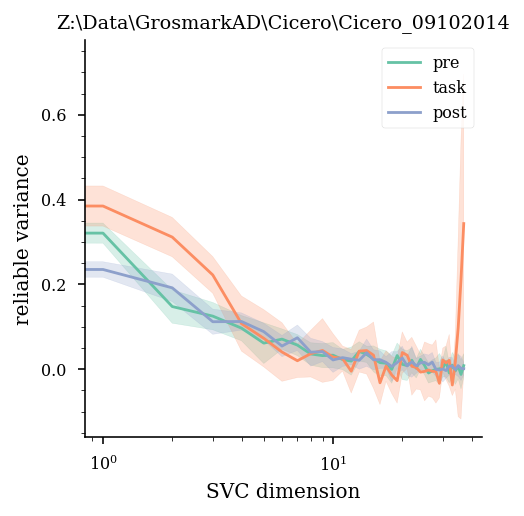

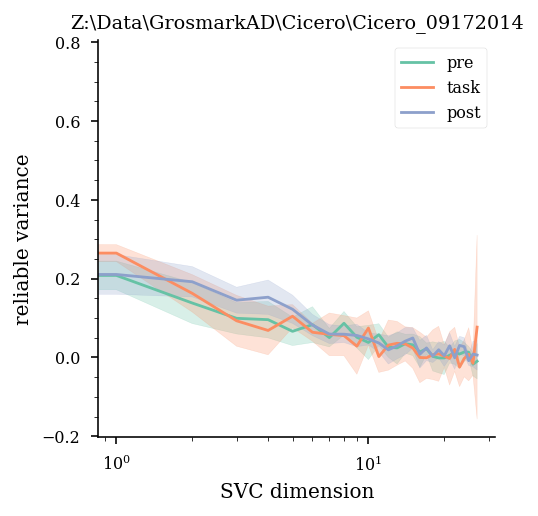

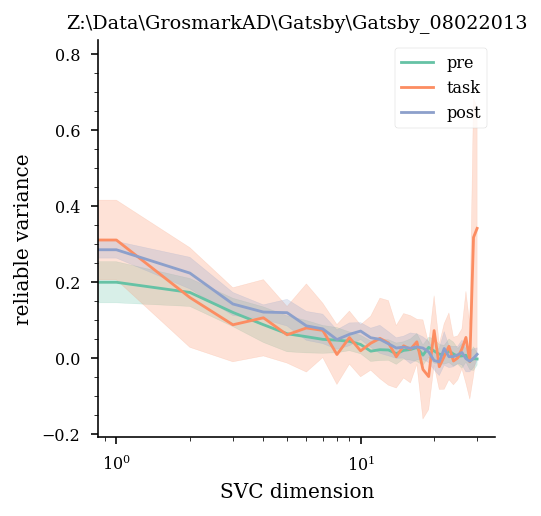

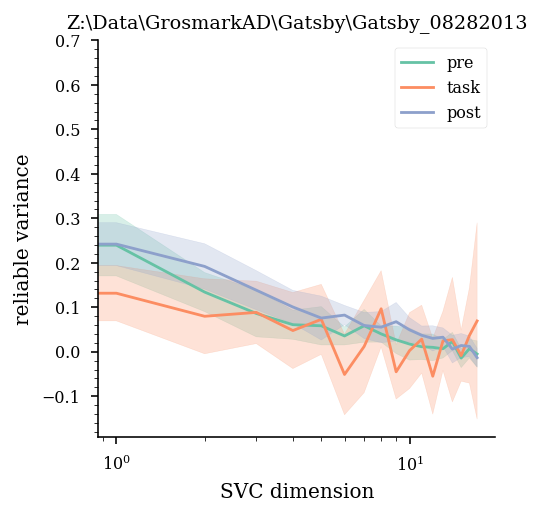

In [182]:
importlib.reload(dimensionality_estimation)

for basepath in df.basepath.unique():

    (cell_metrics,
    st,
    epoch_df,
    behavioral_epochs,
    nrem_epochs,
    wake_epochs,
    ripple_epochs,
    unit_mat) = dimensionality_estimation.load_needed_data(basepath)

    results = dimensionality_estimation.main_analysis(unit_mat,behavioral_epochs,epoch_df,nrem_epochs,wake_epochs)
    results.keys()
    svc_neur = results['svc_neur']

    fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(1,1)),constrained_layout=False)

    cmap = cm.get_cmap('Set2',8)

    labels = ['pre','task','post']
    for i in range(3):
        svc_neur_ = np.array(svc_neur[i])
        plt.plot(svc_neur_.mean(axis=0),color=cmap(i),alpha=1,label=labels[i])
        plt.fill_between(np.arange(svc_neur_.shape[1]),
                        svc_neur_.mean(axis=0)-svc_neur_.std(axis=0),
                        svc_neur_.mean(axis=0)+svc_neur_.std(axis=0),
                        color=cmap(i),alpha=.25)
    ax = plt.gca()
    plt.xscale('log')

    ax.set_aspect(1./ax.get_data_ratio())
                    
    # plt.xlim(0,10**2)
    # plt.ylim(0,.8)

    plt.xlabel('SVC dimension')
    plt.ylabel('reliable variance')
    plt.legend()

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_title(basepath)

In [178]:
svc_neur = results['svc_neur']

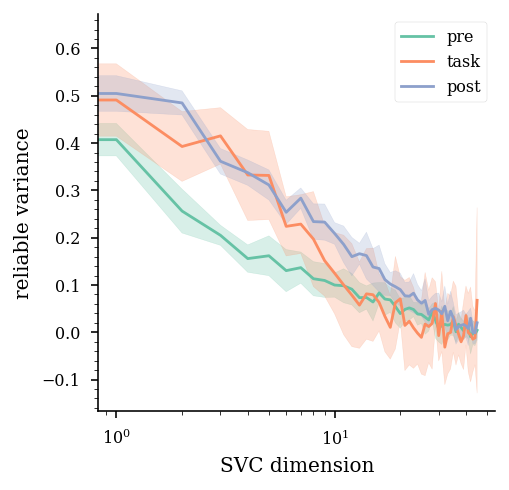

In [181]:
import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.3, subplots=(1,1)),constrained_layout=False)

cmap = cm.get_cmap('Set2',8)

labels = ['pre','task','post']
for i in range(3):
    svc_neur_ = np.array(svc_neur[i])
    plt.plot(svc_neur_.mean(axis=0),color=cmap(i),alpha=1,label=labels[i])
    plt.fill_between(np.arange(svc_neur_.shape[1]),
                    svc_neur_.mean(axis=0)-svc_neur_.std(axis=0),
                    svc_neur_.mean(axis=0)+svc_neur_.std(axis=0),
                    color=cmap(i),alpha=.25)
ax = plt.gca()
plt.xscale('log')

ax.set_aspect(1./ax.get_data_ratio())
                   
plt.xlim(0,10**2)
plt.ylim(0,.8)

plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')
plt.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())

# plt.savefig(os.path.join(fig_save_path,'svc_ripple_dimension.svg'),dpi=300,bbox_inches='tight')


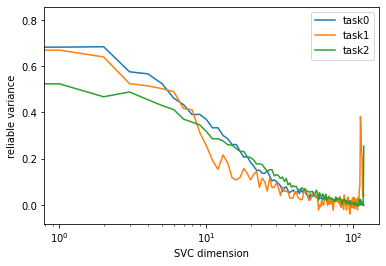

In [9]:
import warnings
warnings.filterwarnings("ignore")

plt.figure()
for i,ep in enumerate(beh_epochs):
    #  do multiple subsets and avg
    svc_neur = [] 
    for _ in range(10):
        scov,varcov,strain,stest = SVCA(unit_mat[ep].data)
        svc_neur.append(scov/varcov)

    plt.plot(np.mean(svc_neur,axis=0),label='task'+str(i))
    # plt.show()
plt.xscale('log')
plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')
plt.legend()

<AxesSubplot:>

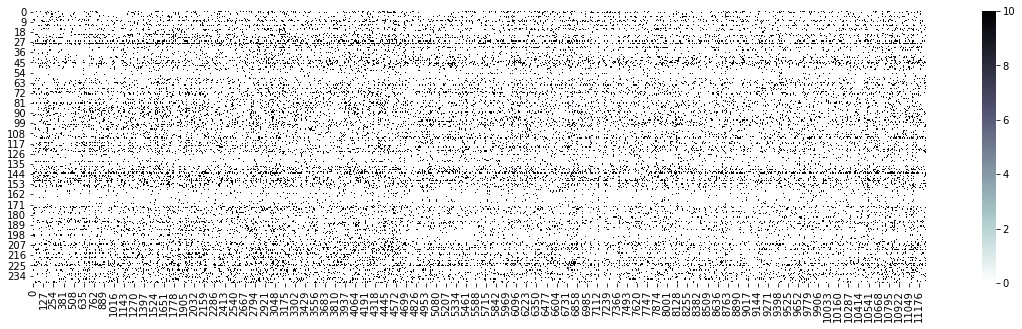

In [119]:
plt.figure(figsize=(20,5))
sns.heatmap(unit_mat.data,vmax=10,cmap='bone_r')

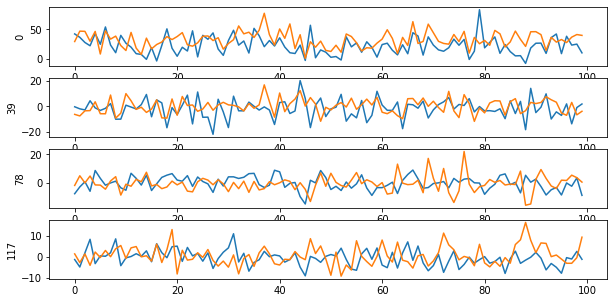

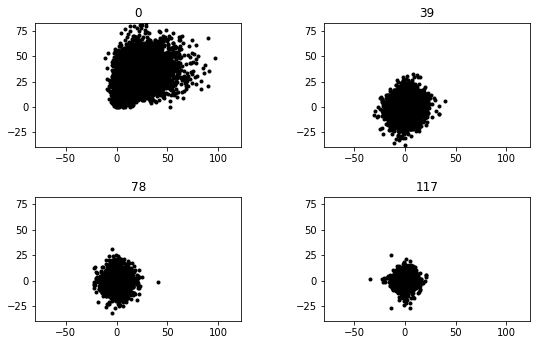

In [18]:
scov,varcov,strain,stest = SVCA(unit_mat.data)

fig,ax = plt.subplots(4,1,figsize=(10,5))
for ax_i,i in enumerate(np.linspace(0,strain.shape[0]-2,4)):
    i = int(i)
    ax[ax_i].plot(strain[i,0:100])
    ax[ax_i].plot(stest[i,0:100])
    ax[ax_i].set_ylabel(i)

fig, axs = plt.subplots(2,2, figsize=functions.set_size('thesis', fraction=1.5, subplots=(2,2)), edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.4)
axs = axs.ravel()
for ax_i,i in enumerate(np.linspace(0,strain.shape[0]-2,4)):
    i = int(i)
    axs[ax_i].plot(strain[i,:],stest[i,:],'.k')
    axs[ax_i].set_title(i)
    axs[ax_i].axis('equal')
    axs[ax_i].set_xlim(np.min([strain,stest]),np.max([strain,stest]))
    axs[ax_i].set_ylim(np.min([strain,stest]),np.max([strain,stest]))

Text(0, 0.5, 'reliable variance')

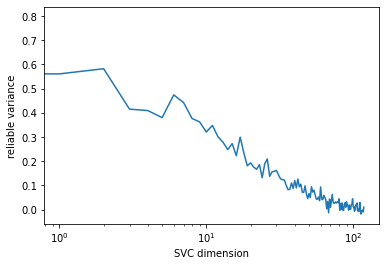

In [55]:
plt.figure()
plt.plot(scov/varcov)
plt.xscale('log')
plt.xlabel('SVC dimension')
plt.ylabel('reliable variance')



In [ ]:
X = unit_mat
NN,NT = X.shape

# split cells into test and train
norder = np.random.permutation(NN)

ntrain1 = ntrain(randperm(len(ntrain), nneur1(n)))
ntest1 = ntest(randperm(len(ntest), nneur1(n)))

sneur, varneur, u, v = SVCA(Ff, min(npc, nneur1(n)), ntrain1, ntest1,	itrain, itest)